In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
from os.path import join
from ast import literal_eval as make_tuple
from scipy.stats import zscore
import numpy as np
from matplotlib.legend import _get_legend_handles_labels
sns.set(style="darkgrid", context="talk")

In [22]:
def capacity_factors_model(model):
    cp_fact = pd.read_csv("/home/users/train014/Repositories/group_5/data/cap_factor_input_all_periods_{}.csv".format(model))
    cp_fact = cp_fact.rename(columns={"Unnamed: 0": "bus_carrier"}).set_index("bus_carrier")
    cp_fact = pd.DataFrame(cp_fact.stack()).rename(columns={0:"capacity_factor"}).reset_index()
    cp_fact.rename(columns={"level_1":"period_stat"}, inplace=True)
    cp_fact["period_stat"] = cp_fact["period_stat"].apply(lambda x: make_tuple(x))
    cp_fact["period"] = cp_fact["period_stat"].apply(lambda x: x[0])
    cp_fact["stat"] = cp_fact["period_stat"].apply(lambda x: x[1])
    cp_fact["bus_carrier"] = cp_fact["bus_carrier"].str.split(" ")
    cp_fact["bus"] = cp_fact["bus_carrier"].apply(lambda x: x[0])
    cp_fact["carrier"] = cp_fact["bus_carrier"].apply(lambda x: x[1])
    cp_fact = cp_fact[["period", "bus", "carrier",  "stat", "capacity_factor"]]
    cp_fact = cp_fact.groupby(["period", "bus", "carrier", "stat"]).mean()
    cp_fact_out = cp_fact.loc[:,:,:,"ave"].copy().rename(columns= {"capacity_factor":"capacity_factor_min"})
    for stat in ["ave", "max"]:
        cp_fact_out["capacity_factor_{}".format(stat)] = cp_fact.loc[:,:,:,stat]
    return cp_fact_out

def gen_share_model(model):
    filepath = Path("/home/users/train014/Repositories/group_5/data/gen_share_per_node_all_periods_model_{}.csv".format(model))
    model_data = pd.read_csv(filepath)
    model_data = model_data.set_index(["bus", "carrier"]).stack().reset_index().rename(columns={0:"GENSHARE",                                                                                      
                                                                           "level_2": "period"})
    model_data = model_data.set_index(["period","bus", "carrier"])
    return model_data

def cap_share_model(model):
    filepath = Path("/home/users/train014/Repositories/group_5/data/cap_share_per_node_all_periods_model_{}.csv".format(model))
    model_data = pd.read_csv(filepath)
    model_data = model_data.set_index(["bus", "carrier"]).stack().reset_index().rename(columns={0:"CAPSHARE",                                                                                      
                                                                           "level_2": "period"})
    model_data = model_data.set_index(["period","bus", "carrier"])
    return model_data

In [37]:
cap_factors_CNRM_indexed = capacity_factors_model("CNRM").reset_index()
cap_factors_CNRM_indexed["model"] = "CNRM"
#cap_factors_CNRM_indexed = cap_factors_CNRM_indexed.groupby(["model","period", "bus", "carrier"]).mean()
cap_factors_ICHEC_indexed = capacity_factors_model("ICHEC").reset_index()
cap_factors_ICHEC_indexed["model"] = "ICHEC"
#cap_factors_ICHEC_indexed = cap_factors_ICHEC_indexed.groupby(["model","period", "bus", "carrier"]).mean()
cap_factors_MPI_indexed = capacity_factors_model("MPI").reset_index()
cap_factors_MPI_indexed["model"] = "MPI"
#cap_factors_MPI_indexed = cap_factors_MPI_indexed.groupby(["model","period", "bus", "carrier"]).mean()
cap_factors_all = pd.concat([cap_factors_CNRM_indexed, cap_factors_ICHEC_indexed, cap_factors_MPI_indexed],
                            ignore_index = True)
cap_factors_all = cap_factors_all.groupby(["model","period", "bus", "carrier"]).mean()

In [52]:
gen_shareCNRM = gen_share_model("CNRM").reset_index()
gen_shareCNRM["model"] = "CNRM"
gen_shareICHEC = gen_share_model("ICHEC").reset_index()
gen_shareICHEC["model"] = "ICHEC"
gen_shareMPI= gen_share_model("MPI").reset_index()
gen_shareMPI["model"] = "MPI"
genshare_all = pd.concat([gen_shareCNRM, gen_shareICHEC, gen_shareMPI],
                            ignore_index = True)
genshare_all = genshare_all.groupby(["model","period", "bus", "carrier"]).mean()

In [63]:
joned_all_gen = genshare_all.join(cap_factors_all).dropna()

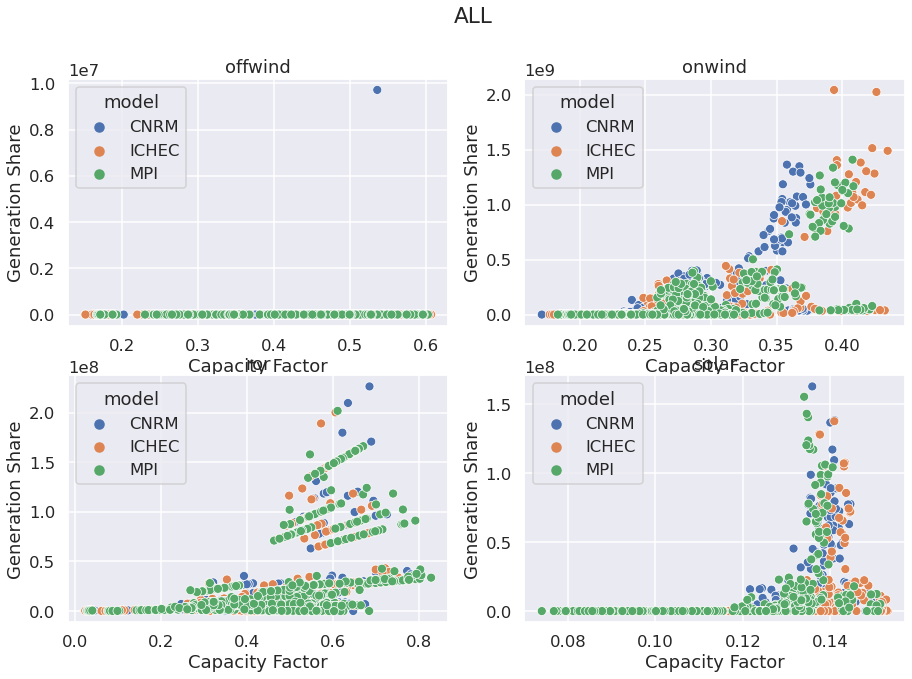

In [180]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("ALL")
axes_pointer = axes.flatten()
for i, carrier in enumerate(['offwind', 'onwind', 'ror', 'solar']):
    sns.scatterplot(data=joned_all_gen.loc[:,:,:,carrier], x="capacity_factor_ave", y="GENSHARE", hue="model",
                    ax = axes_pointer[i], legend = True)
    axes_pointer[i].set_title(carrier)
    axes_pointer[i].set_xlabel("Capacity Factor")
    axes_pointer[i].set_ylabel("Generation Share")
    #axes_pointer[i].set_xlim([0,1])
    #axes_pointer[i].set(yscale="log")

In [67]:
cap_shareCNRM = cap_share_model("CNRM")

cap_shareCNRM = cap_share_model("CNRM").reset_index()
cap_shareCNRM["model"] = "CNRM"
cap_shareICHEC = cap_share_model("ICHEC").reset_index()
cap_shareICHEC["model"] = "ICHEC"
cap_shareMPI= cap_share_model("MPI").reset_index()
cap_shareMPI["model"] = "MPI"
capshare_all = pd.concat([cap_shareCNRM, cap_shareICHEC, cap_shareMPI],
                            ignore_index = True)
capshare_all = capshare_all.groupby(["model","period", "bus", "carrier"]).mean()

In [148]:
joned_all_cap= capshare_all.join(cap_factors_all)
capshare_ocgt = joned_all_cap[joned_all_cap.capacity_factor_min.isna()][["CAPSHARE"]]

In [142]:
joned_all_cap_cpav = joned_all_cap[["capacity_factor_ave"]].dropna()
joned_all_cap_cpav_onwind = joned_all_cap_cpav.loc[:,:,:,"onwind"].rename(columns={"capacity_factor_ave":"onwind"})
joned_all_cap_cpav_offwind = joned_all_cap_cpav.loc[:,:,:,"offwind"].rename(columns={"capacity_factor_ave":"offwind"})
joned_all_cap_cpav_solar = joned_all_cap_cpav.loc[:,:,:,"solar"].rename(columns={"capacity_factor_ave":"solar"})
joned_all_cap_cpav_ror = joned_all_cap_cpav.loc[:,:,:,"ror"].rename(columns={"capacity_factor_ave":"ror"})
cp_columns = joned_all_cap_cpav_solar.join(joned_all_cap_cpav_offwind).join(joned_all_cap_cpav_onwind).join(joned_all_cap_cpav_ror)
cp_columns = cp_columns.fillna(0)

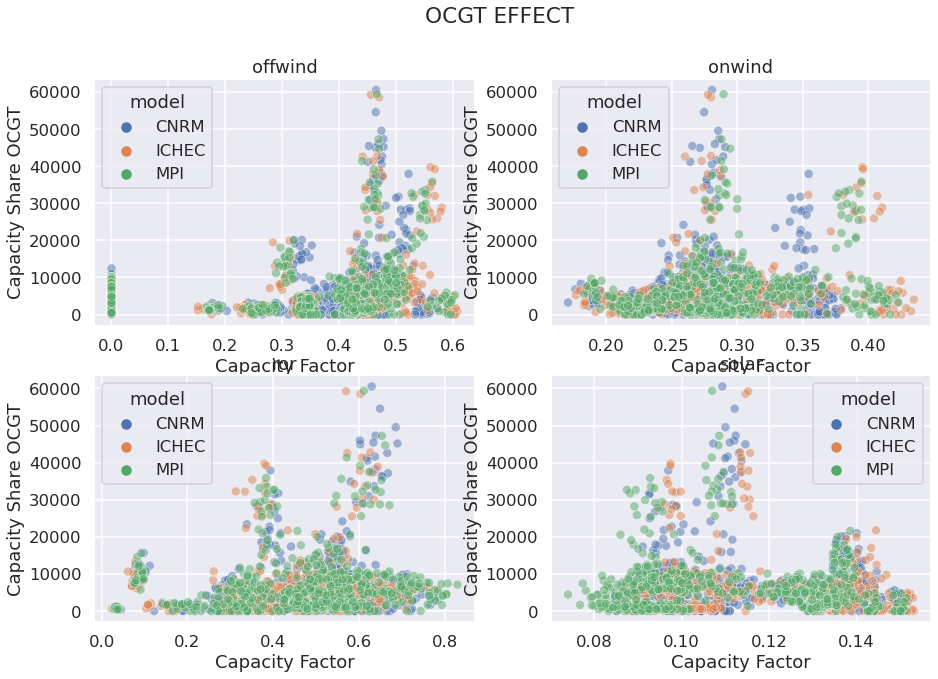

In [181]:
cp_column_capshare = cp_columns.join(capshare_ocgt)
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("OCGT EFFECT")
axes_pointer = axes.flatten()
for i, carrier in enumerate(['offwind', 'onwind', 'ror', 'solar']):
    sns.scatterplot(data=cp_column_capshare, 
                    x=carrier, y="CAPSHARE", hue="model", alpha=0.5,
                    ax = axes_pointer[i], legend = True)
    axes_pointer[i].set_title(carrier)
    axes_pointer[i].set_xlabel("Capacity Factor")
    axes_pointer[i].set_ylabel("Capacity Share OCGT")

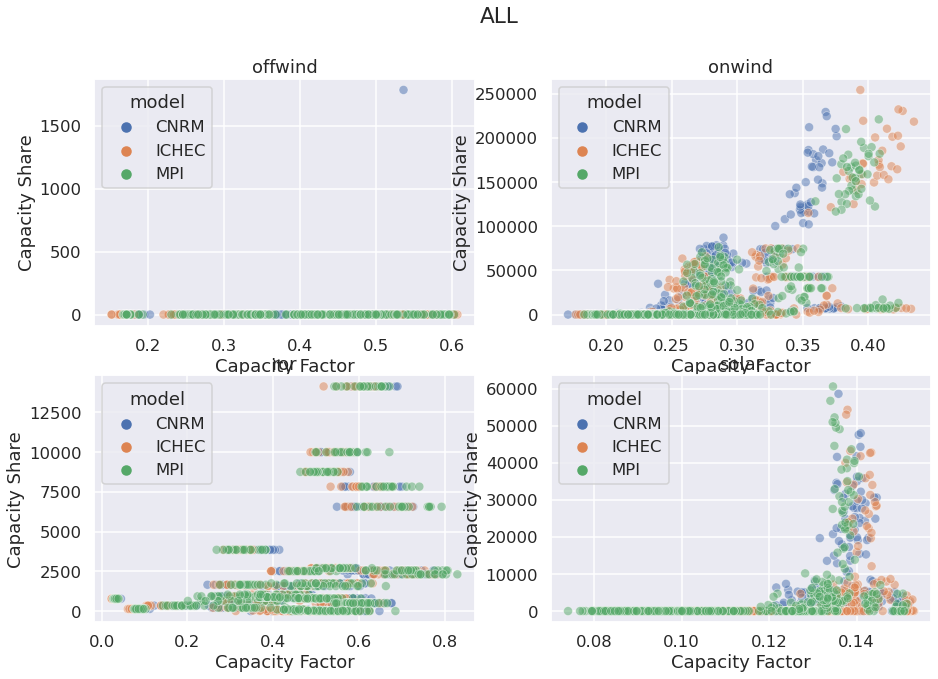

In [182]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("ALL")
axes_pointer = axes.flatten()
for i, carrier in enumerate(['offwind', 'onwind', 'ror', 'solar']):
    sns.scatterplot(data=joned_all_cap.loc[:,:,:,carrier], 
                    x="capacity_factor_ave", y="CAPSHARE", hue="model", alpha=0.5,
                    ax = axes_pointer[i], legend = True)
    axes_pointer[i].set_title(carrier)
    axes_pointer[i].set_xlabel("Capacity Factor")
    axes_pointer[i].set_ylabel("Capacity Share")
    #axes_pointer[i].set_xlim([0,1])
    #axes_pointer[i].set(yscale="log")

In [183]:
gencap = joned_all_cap.join(joned_all_gen["GENSHARE"])

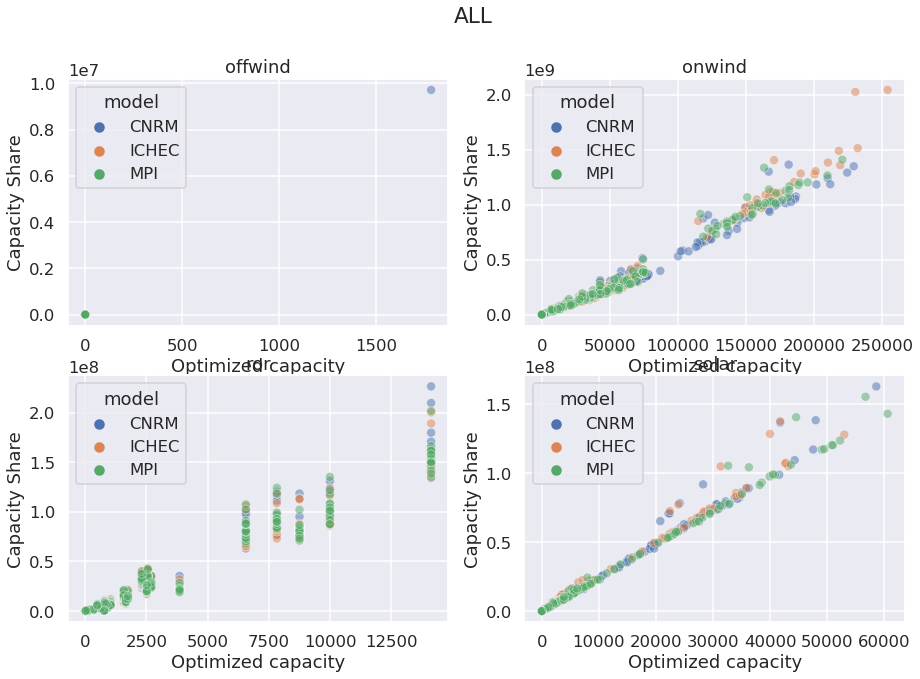

In [184]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("ALL")
axes_pointer = axes.flatten()
for i, carrier in enumerate(['offwind', 'onwind', 'ror', 'solar']):
    sns.scatterplot(data=gencap.loc[:,:,:,carrier], 
                    x="CAPSHARE", y="GENSHARE", hue="model", alpha=0.5,
                    ax = axes_pointer[i], legend = True)
    axes_pointer[i].set_title(carrier)
    axes_pointer[i].set_xlabel("Optimized capacity")
    axes_pointer[i].set_ylabel("Capacity Share")
    #axes_pointer[i].set_xlim([0,1])
    #axes_pointer[i].set(yscale="log")

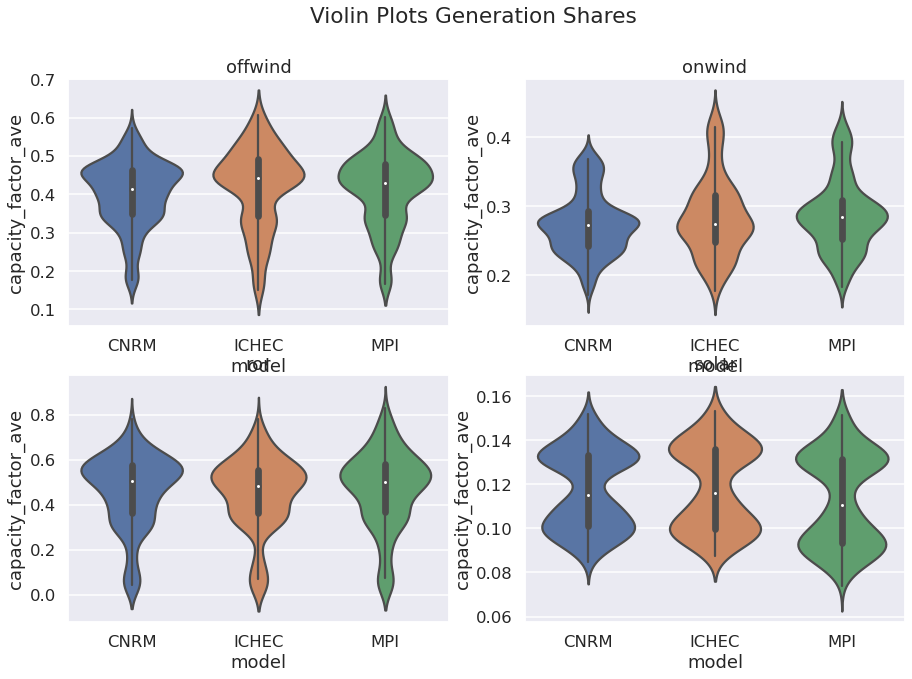

In [185]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("Violin Plots Generation Shares")
axes_pointer = axes.flatten()
for i, carrier in enumerate(['offwind', 'onwind', 'ror', 'solar']):
    sns.violinplot(data = joned_all_gen.loc[:,:,:,carrier].reset_index(), 
                    x = "model", y = "capacity_factor_ave", ax = axes_pointer[i] )
    axes_pointer[i].set_title(carrier)

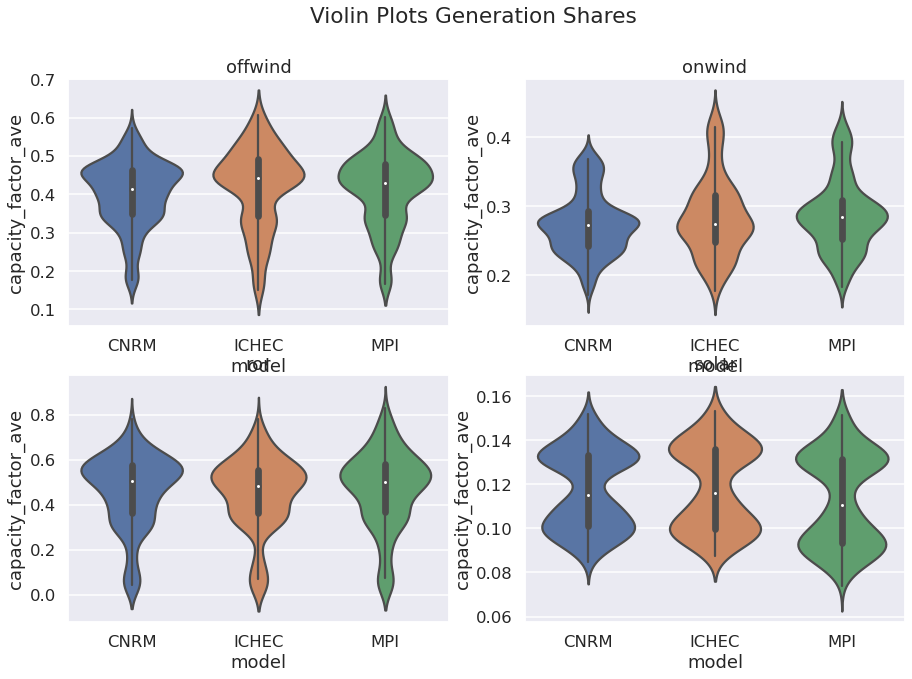

In [186]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("Violin Plots Generation Shares")
axes_pointer = axes.flatten()
for i, carrier in enumerate(['offwind', 'onwind', 'ror', 'solar']):
    sns.violinplot(data = joned_all_gen.loc[:,:,:,carrier].reset_index(), 
                    x = "model", y = "capacity_factor_ave", ax = axes_pointer[i] )
    axes_pointer[i].set_title(carrier)

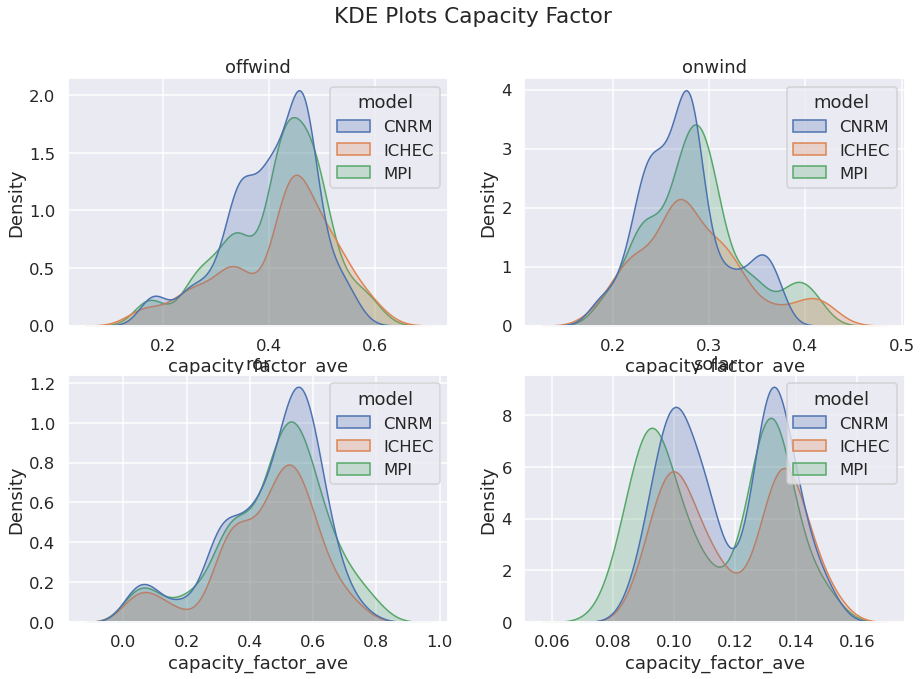

In [187]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("KDE Plots Capacity Factor")
axes_pointer = axes.flatten()
for i, carrier in enumerate(['offwind', 'onwind', 'ror', 'solar']):
    sns.kdeplot(data = joned_all_gen.loc[:,:,:,carrier].reset_index(), 
                    x = "capacity_factor_ave", ax = axes_pointer[i] , fill = True,
                    hue = "model")
    axes_pointer[i].set_title(carrier)

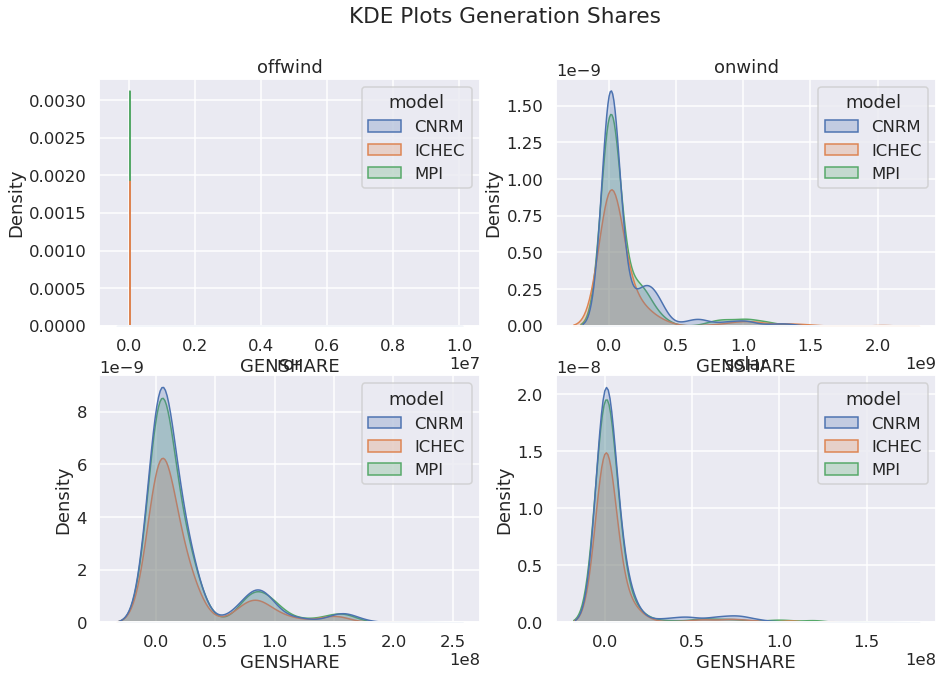

In [188]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("KDE Plots Generation Shares")
axes_pointer = axes.flatten()
for i, carrier in enumerate(['offwind', 'onwind', 'ror', 'solar']):
    sns.kdeplot(data = joned_all_gen.loc[:,:,:,carrier].reset_index(), 
                    x = "GENSHARE", ax = axes_pointer[i] , fill = True,
                    hue = "model")
    axes_pointer[i].set_title(carrier)

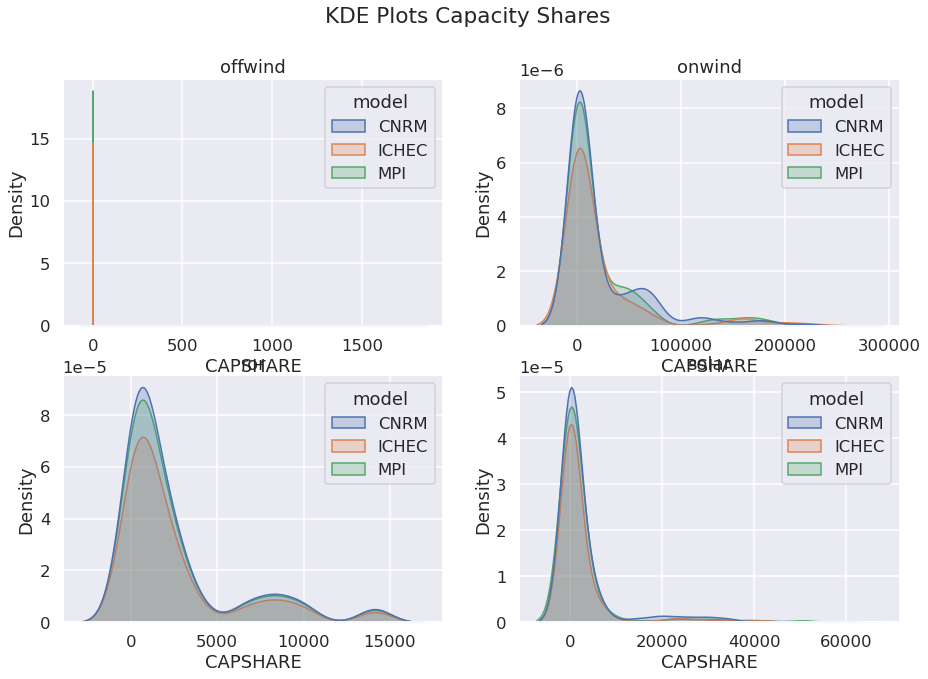

In [189]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("KDE Plots Capacity Shares")
axes_pointer = axes.flatten()
for i, carrier in enumerate(['offwind', 'onwind', 'ror', 'solar']):
    sns.kdeplot(data = joned_all_cap.loc[:,:,:,carrier].reset_index(), 
                    x = "CAPSHARE", ax = axes_pointer[i] , fill = True,
                    hue = "model")
    axes_pointer[i].set_title(carrier)

/home/users/train014/.conda/envs/pypsa-eur/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


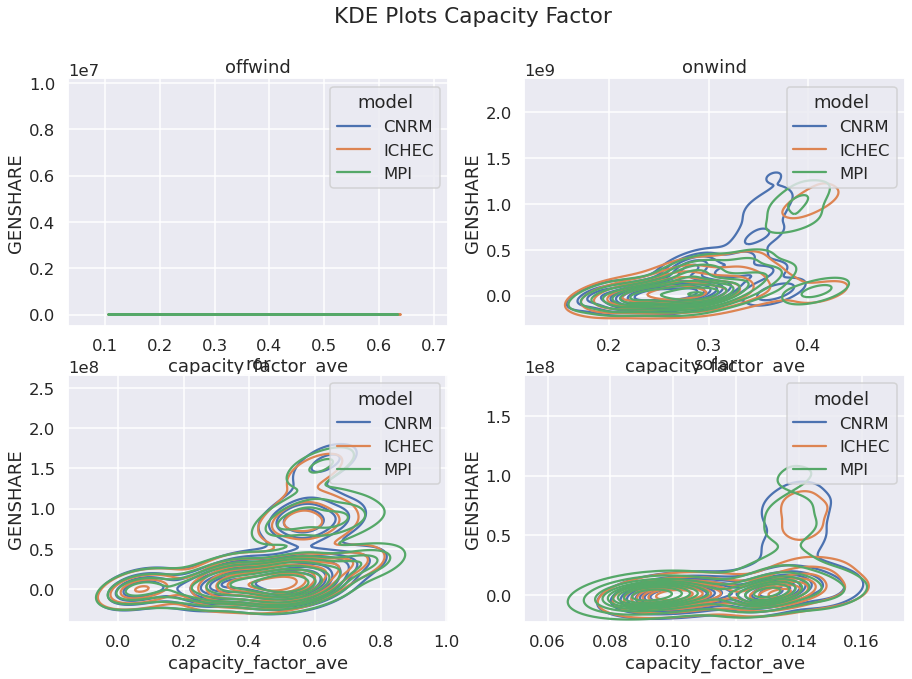

In [191]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("KDE Plots Capacity Factor")
axes_pointer = axes.flatten()
for i, carrier in enumerate(['offwind', 'onwind', 'ror', 'solar']):
    sns.kdeplot(data = joned_all_gen.loc[:,:,:,carrier].reset_index(), 
                    x = "capacity_factor_ave", y="GENSHARE", ax = axes_pointer[i] ,
                    hue = "model")
    axes_pointer[i].set_title(carrier)

/home/users/train014/.conda/envs/pypsa-eur/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


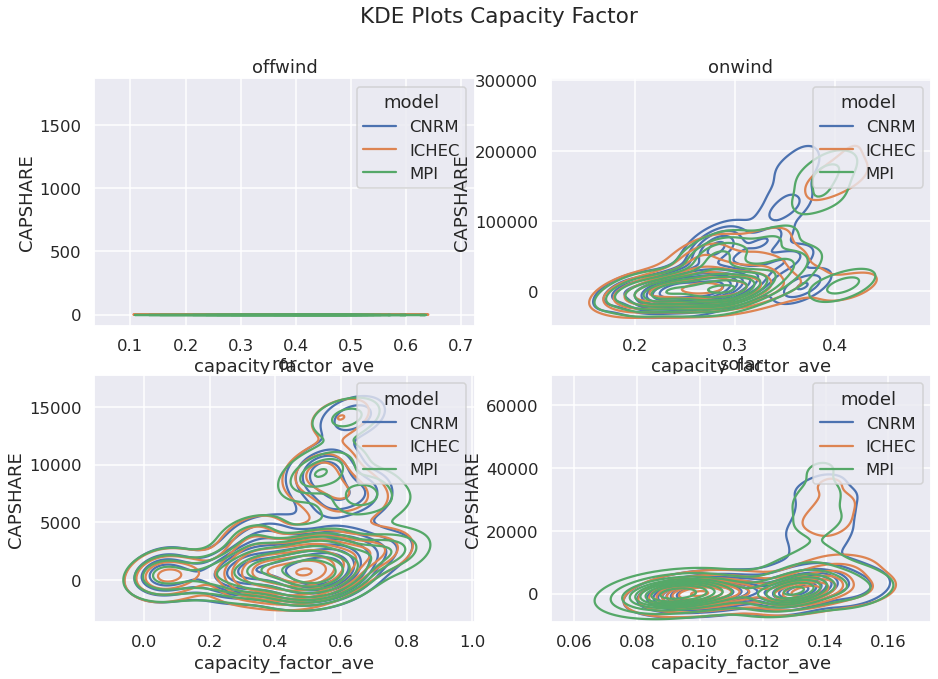

In [192]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("KDE Plots Capacity Factor")
axes_pointer = axes.flatten()
for i, carrier in enumerate(['offwind', 'onwind', 'ror', 'solar']):
    sns.kdeplot(data = joned_all_cap.loc[:,:,:,carrier].reset_index(), 
                    x = "capacity_factor_ave", y="CAPSHARE", ax = axes_pointer[i] ,
                    hue = "model")
    axes_pointer[i].set_title(carrier)